In [267]:
import sys

sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx
import seaborn as sns
import pandas as pd
import pickle

from spikeometric.models import BernoulliGLM
from spikeometric.stimulus import RegularStimulus
from spikeometric.datasets import NormalGenerator, UniformGenerator
from torch_geometric.utils import to_networkx, from_networkx, to_dense_adj

from CD_methods import observational_learner_Poisson, interventional_learner_Poisson
from functions import *

# Get data

In [342]:
network_data = torch.load('../data/c_elegans_data.pt')

In [343]:
G = to_networkx(network_data, node_attrs = ['position'])
position_dict = nx.get_node_attributes(G, 'position')
ap_axis = []
xy_position_dict = dict()
for node in position_dict:
    y = np.random.random()
    x = position_dict[node]
    xy_position_dict[node] = np.array([x, y])

In [344]:
n_neurons = G.number_of_nodes()
n_edges = G.number_of_edges()
print(n_neurons, n_edges)

279 2194


## Select opsin

In [498]:
sample_space = []
upper = 0.85 # head
lower = 0.
for neuron in position_dict:
    if position_dict[neuron] > lower and position_dict[neuron] < upper:
        sample_space.append(neuron)

print('Size of sample space = ', len(sample_space))

Size of sample space =  279


In [504]:
n_obs = 20
graphs_sampled = []
for j in range(5):
    index_obs = np.sort(np.random.choice(sample_space, size = n_obs, replace = False))
    G_true=nx.subgraph(G, index_obs)
    graphs_sampled.append(G_true)
    #G_true = G_sampled.copy()
    #G_true.remove_nodes_from(nx.isolates(G_sampled))
    #index_obs = list(G_true.nodes())
    print('n_obs=',G_true.number_of_nodes(), 'n_edges=',G_true.number_of_edges())

n_obs= 20 n_edges= 12
n_obs= 20 n_edges= 17
n_obs= 20 n_edges= 11
n_obs= 20 n_edges= 14
n_obs= 20 n_edges= 12


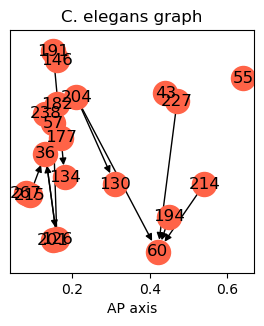

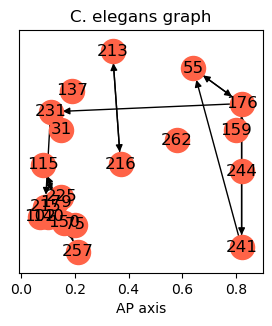

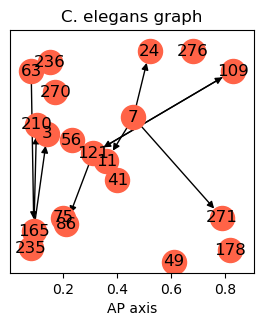

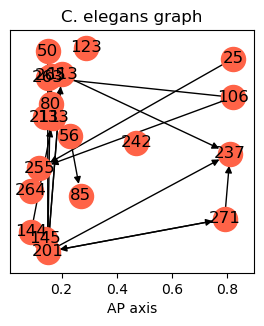

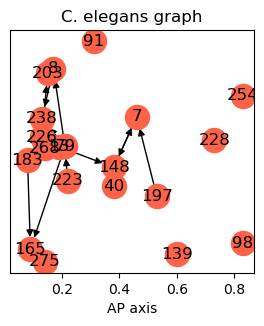

In [505]:
cm=1/2.54
#color_map = ['tomato' if node in index_opsin else 'cornflowerblue' for node in G_true]
for j in range(5):
    G_true = graphs_sampled[j]
    fig, ax = plt.subplots(figsize=(8*cm,8*cm))
    ax.set_title('C. elegans graph')
    nx.draw_networkx(G_true, 
                     pos=xy_position_dict, 
                     arrows=True, 
                     with_labels=True, 
                     arrowsize=10, 
                     node_size=300, 
                     node_color='tomato',
                     ax=ax)
    ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    ax.set_xlabel('AP axis')
    plt.show()

### Generate observational data

In [506]:
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)
n_timesteps = 10**4
alpha=1e-2 # sig level

In [507]:
graphs_learned_null = []

In [ ]:
for j in range(5):
    G_true = graphs_sampled[j]
    index_obs = list(G_true.nodes())
    spike_data = dict()
    stimulus_mask = torch.zeros(n_neurons, dtype=torch.bool)
    spikes = neuron_model.simulate(network_data, n_steps=n_timesteps, verbose=False)
    spike_data['null'] = spikes[index_obs]

    G_learned_null = observational_learner_Poisson(spike_data, node_list=index_obs, alpha = alpha)
    graphs_learned_null.append(G_learned_null)
    
    print('shd =',compute_SHD(G_learned=G_learned_null, G_true=G_true))
    print('fp =',count_false_positive(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    print('fn =',count_false_negative(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))

100%|███████████████████████████████████████████| 20/20 [02:44<00:00,  8.22s/it]


shd = 5
fp = 5
fn = 0


  0%|                                                    | 0/20 [00:00<?, ?it/s]

In [277]:


print('tpr=',compute_sensitivity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
print('tnr=',compute_specificity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))

shd= 7
fp= 7
fn= 0
tpr= 0.8333333333333334
tnr= 1.0


In [375]:
optogenetic_stimulation_dict = dict()

In [377]:
for j in range(5):
    G_learned_null = graphs_learned_null[j]
    G_true = graphs_sampled[j]
    index_obs = list(G_true.nodes())
    optogenetic_stimulation_dict[j] = {}
    shd_null = compute_SHD(G_learned=G_learned_null, G_true=G_true)
    
    for prob_activated in [0.1, 0.5, 0.9]:
        G_learned = G_learned_null.copy()
        optogenetic_stimulation_dict[j][prob_activated] = dict()
        optogenetic_stimulation_dict[j][prob_activated]['SHD'] = {} #[shd_null]

        for n in range(5): # trials
            G_learned = G_learned_null.copy()
            optogenetic_stimulation_dict[j][prob_activated]['SHD'][n] = [shd_null]
            
            for _ in tqdm(range(15)): # experiments
                spike_data_obs = dict()

                # optogenetic stimulation
                stimulus_mask = torch.rand(n_neurons) < prob_activated
                index_opsin = [node for node in G_true if node in np.where(stimulus_mask)[0]]
                intervention_str = '_'.join(str(x) for x in index_opsin) 

                neuron_model.add_stimulus(lambda t: 1.1*(t % 10 < 3)*stimulus_mask) # all nodes with opsin are stimulated

                spikes = neuron_model.simulate(network_data, n_steps=10**4, verbose=False)    
                spike_data_obs[intervention_str] = spikes[index_obs]    

                # learn graph from interventional data
                G_learned = interventional_learner_Poisson(
                    spike_data_obs,
                    node_list=index_obs, 
                    stimulation_protocol=[index_opsin], # list of nodes with opsin 
                    SCM_learned=G_learned,
                    alpha = alpha,
                    verbose=False)

                SHD_learned = compute_SHD(G_true=G_true, G_learned=G_learned)
                optogenetic_stimulation_dict[j][prob_activated]['SHD'][n].append(SHD_learned)

100%|███████████████████████████████████████████| 15/15 [00:36<00:00,  2.42s/it]


In [379]:
optogenetic_stimulation_dict[0]

{0.1: {'SHD': {0: [15, 14, 11, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9],
   1: [15, 13, 11, 11, 9, 9, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6],
   2: [15, 13, 13, 12, 12, 10, 9, 9, 8, 8, 7, 7, 5, 5, 6, 6],
   3: [15, 14, 12, 11, 11, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 8],
   4: [15, 13, 13, 12, 12, 12, 12, 10, 10, 11, 10, 10, 10, 10, 10, 10]}},
 0.5: {'SHD': {0: [15, 13, 12, 9, 8, 8, 7, 7, 6, 6, 6, 4, 4, 5, 5, 5],
   1: [15, 14, 10, 4, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2],
   2: [15, 13, 7, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4],
   3: [15, 10, 9, 7, 4, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1],
   4: [15, 13, 13, 10, 9, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2]}},
 0.9: {'SHD': {0: [15, 14, 12, 10, 9, 9, 9, 7, 6, 6, 5, 5, 5, 5, 5, 4],
   1: [15, 13, 13, 13, 12, 12, 11, 10, 10, 11, 11, 9, 9, 9, 10, 10],
   2: [15, 15, 15, 13, 12, 12, 12, 11, 10, 9, 9, 9, 8, 8, 8, 8],
   3: [15, 11, 11, 10, 9, 8, 8, 8, 8, 7, 7, 5, 5, 4, 4, 3],
   4: [15, 14, 12, 12, 12, 11, 11, 10, 10, 9, 8, 7, 7, 7, 5, 5]}}}

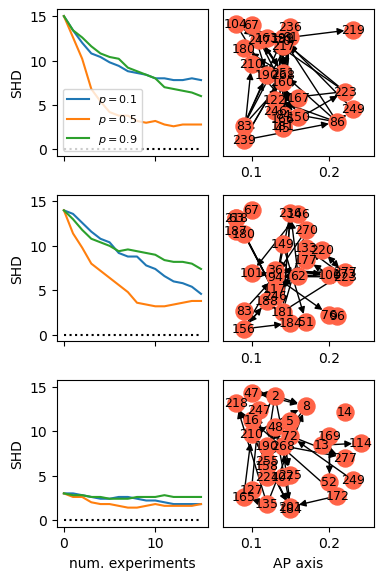

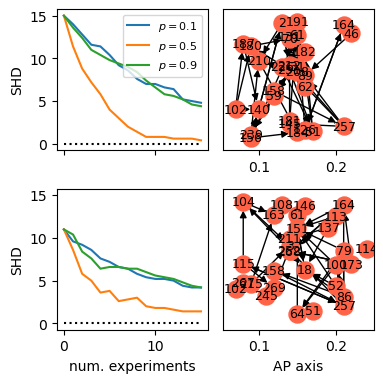

In [497]:
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(10*cm,15*cm),sharey='col',sharex='col')
xy = [[(0,0),(0,1)],[(1,0),(1,1)],[(2,0),(2,1)],[(3,0),(3,1)],[(4,0),(4,1)]]
for idx, j in enumerate(range(3)):
    ax1 = axs[xy[j][1]]
    ax2 = axs[xy[j][0]]

    G_true = graphs_sampled[j]
    #ax.set_title('C. elegans graph')
    nx.draw_networkx(G_true, 
                     pos=xy_position_dict, 
                     arrows=True, 
                     with_labels=True,
                     font_size=9,
                     arrowsize=10, 
                     node_size=150, 
                     node_color='tomato',
                     ax=ax1
                    )
    #ax1.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    #ax1.set_xlabel('AP axis')    
    
    for prob in optogenetic_stimulation_dict[j]:
        shd_df = pd.DataFrame(optogenetic_stimulation_dict[j][prob]['SHD'])
        ax2.plot(shd_df.mean(axis=1), label=f'$p=${np.round(prob, 1)}')
    ax2.hlines(y=0, xmin=0, xmax=15, linestyles='dotted', color='black')
    #plt.xlabel('number of experiments')
    ax2.set_ylabel('SHD')
    ax1.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

    if idx==2:
        ax2.set_xlabel('num. experiments')
        ax1.set_xlabel('AP axis')
    if idx==0:
        ax2.legend(prop={'size': 8})
plt.tight_layout()
plt.savefig('../figures/genetic_expression_prob1.pdf')


fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(10*cm,10*cm),sharey='col',sharex='col')
fig.set_tight_layout(True)
xy = [[(0,0),(0,1)],[(1,0),(1,1)],[(2,0),(2,1)],[(3,0),(3,1)],[(4,0),(4,1)]]
for idx, j in enumerate([3,4]):
    ax1 = axs[xy[idx][1]]
    ax2 = axs[xy[idx][0]]

    G_true = graphs_sampled[j]
    #ax.set_title('C. elegans graph')
    nx.draw_networkx(G_true, 
                     pos=xy_position_dict, 
                     arrows=True, 
                     with_labels=True,
                     font_size=9,
                     arrowsize=10, 
                     node_size=150, 
                     node_color='tomato',
                     ax=ax1
                    )
    #ax1.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    #ax1.set_xlabel('AP axis')    
    
    for prob in optogenetic_stimulation_dict[j]:
        shd_df = pd.DataFrame(optogenetic_stimulation_dict[j][prob]['SHD'])
        ax2.plot(shd_df.mean(axis=1), label=f'$p=${np.round(prob, 1)}')
    ax2.hlines(y=0, xmin=0, xmax=15, linestyles='dotted', color='black')
    #plt.xlabel('number of experiments')
    ax2.set_ylabel('SHD')
    ax1.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

    if idx==1:
        ax2.set_xlabel('num. experiments')
        ax1.set_xlabel('AP axis')
    if idx==0:
        ax2.legend(prop={'size': 8})
plt.tight_layout()
plt.savefig('../figures/genetic_expression_prob2.pdf')

In [492]:
final_shd = {0.1:[], 0.5:[], 0.9:[]}
init_shd = {0.1:[], 0.5:[], 0.9:[]}

for j in range(5):
    for prob in optogenetic_stimulation_dict[j]:
        shd_df = pd.DataFrame(optogenetic_stimulation_dict[j][prob]['SHD'])
        final_shd[prob].append(shd_df.mean(axis=1).values[-1])
        init_shd[prob].append(shd_df.mean(axis=1).values[0])

In [495]:
for prob in final_shd:
    print(np.mean(final_shd[prob]), np.std(final_shd[prob]))
print(np.mean(init_shd[prob]), np.std(init_shd[prob]))

4.64 1.9116485032557633
2.04 1.1689311356961967
4.92 1.6424372134118248
11.6 4.5431266766402185
